# Q17. pix2pix: cGAN(U-Net-Generator, PatchGAN) 

## 1. 데이터 로드 및 Augmentation

### 1-1. 데이터 로드

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np

import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

(256, 512, 3)


<Figure size 1440x720 with 0 Axes>

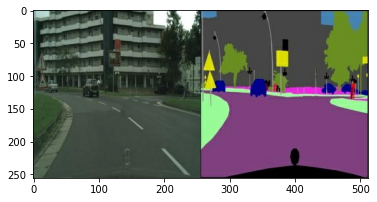

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/'
sample_image = tf.io.read_file(str(data_path+'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)
plt.figure(figsize=(20,10))
plt.figure()
plt.imshow(sample_image)

tf.Tensor([175. 205. 197.], shape=(3,), dtype=float32)


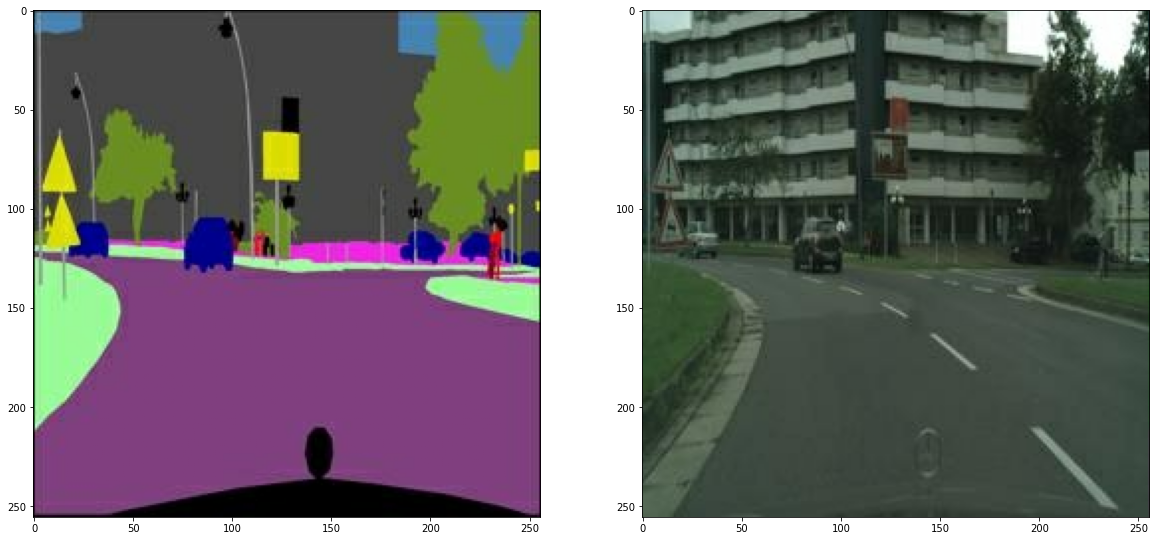

In [3]:
def load(image_file):
    # image file to a uint8 tensor(0~255)
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    
    # Split into two tensors
    w = tf.shape(image)[1] // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :] 

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image


sample_path = data_path + 'train/1.jpg'
inp, re = load(sample_path)
print(re[0,0])

plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(inp / 255.0)
plt.subplot(1,2,2); plt.imshow(re / 255.0)

### 1-2. Augmentation

- random_jitter 함수 정의
1. resizing 256x256 to 286x286
2. random cropping
3. random mirroring

In [4]:
# The training set consist of 1000 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image])
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image, real_image):
    #resizing
    input_image, real_image = resize(input_image, real_image, 286, 286)
    #cropping
    input_image, real_image = random_crop(input_image, real_image)
    #random mirroring
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

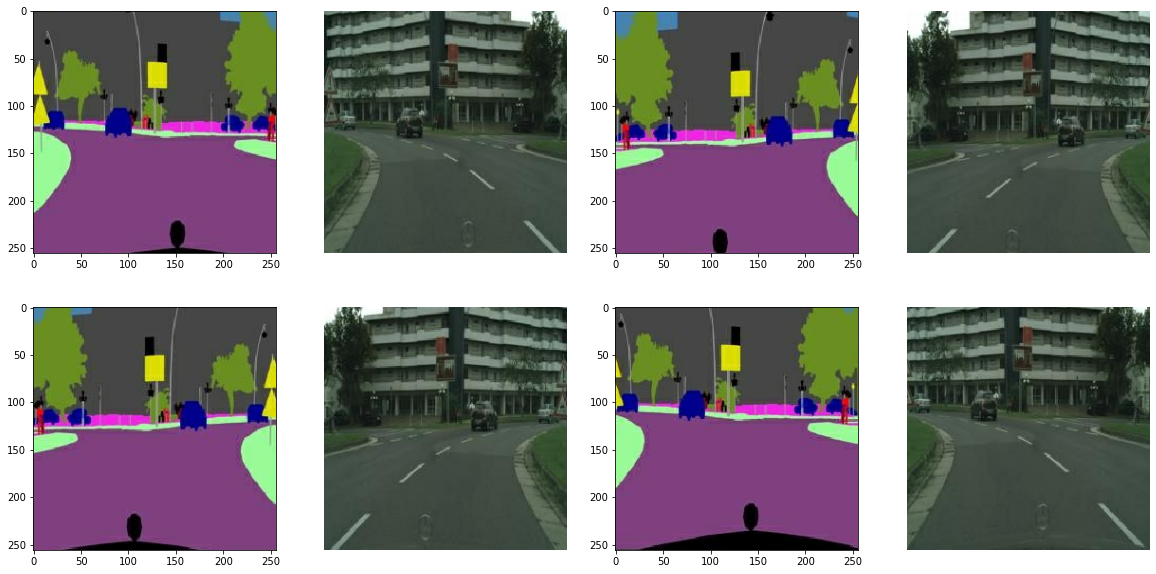

In [5]:
plt.figure(figsize=(20, 10))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 4, 2*i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.subplot(2, 4, 2*i + 2)
    plt.imshow(rj_re / 255.0)
    plt.axis('off')
plt.show()

### 1-3. 훈련/테스트셋 전처리 및 입력 파이프라인 구축

In [6]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [7]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [8]:
train_dataset = tf.data.Dataset.list_files(str(data_path +'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [9]:
try:
    test_dataset = tf.data.Dataset.list_files(str(data_path +'val/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(data_path +'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## 2. U-Net-Generator 구축

### 2-1. 인코더 및 디코더 정의

In [10]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        # 첫번째 EncoderBlock의 경우 Batch Normalization을 생략
        self.blocks = [] 
        for f in filters:
            self.blocks.append(
                EncodeBlock(f, use_bn=False if f==64 else True)
            )
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        # 3번째 block까지 Dropout 사용
        # output 차원수 3, filter 사이즈 4, stride 2, padding = same
        self.blocks = [] 
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f, dropout=True))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))

        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

### 2-2. UNet skip connection 구현

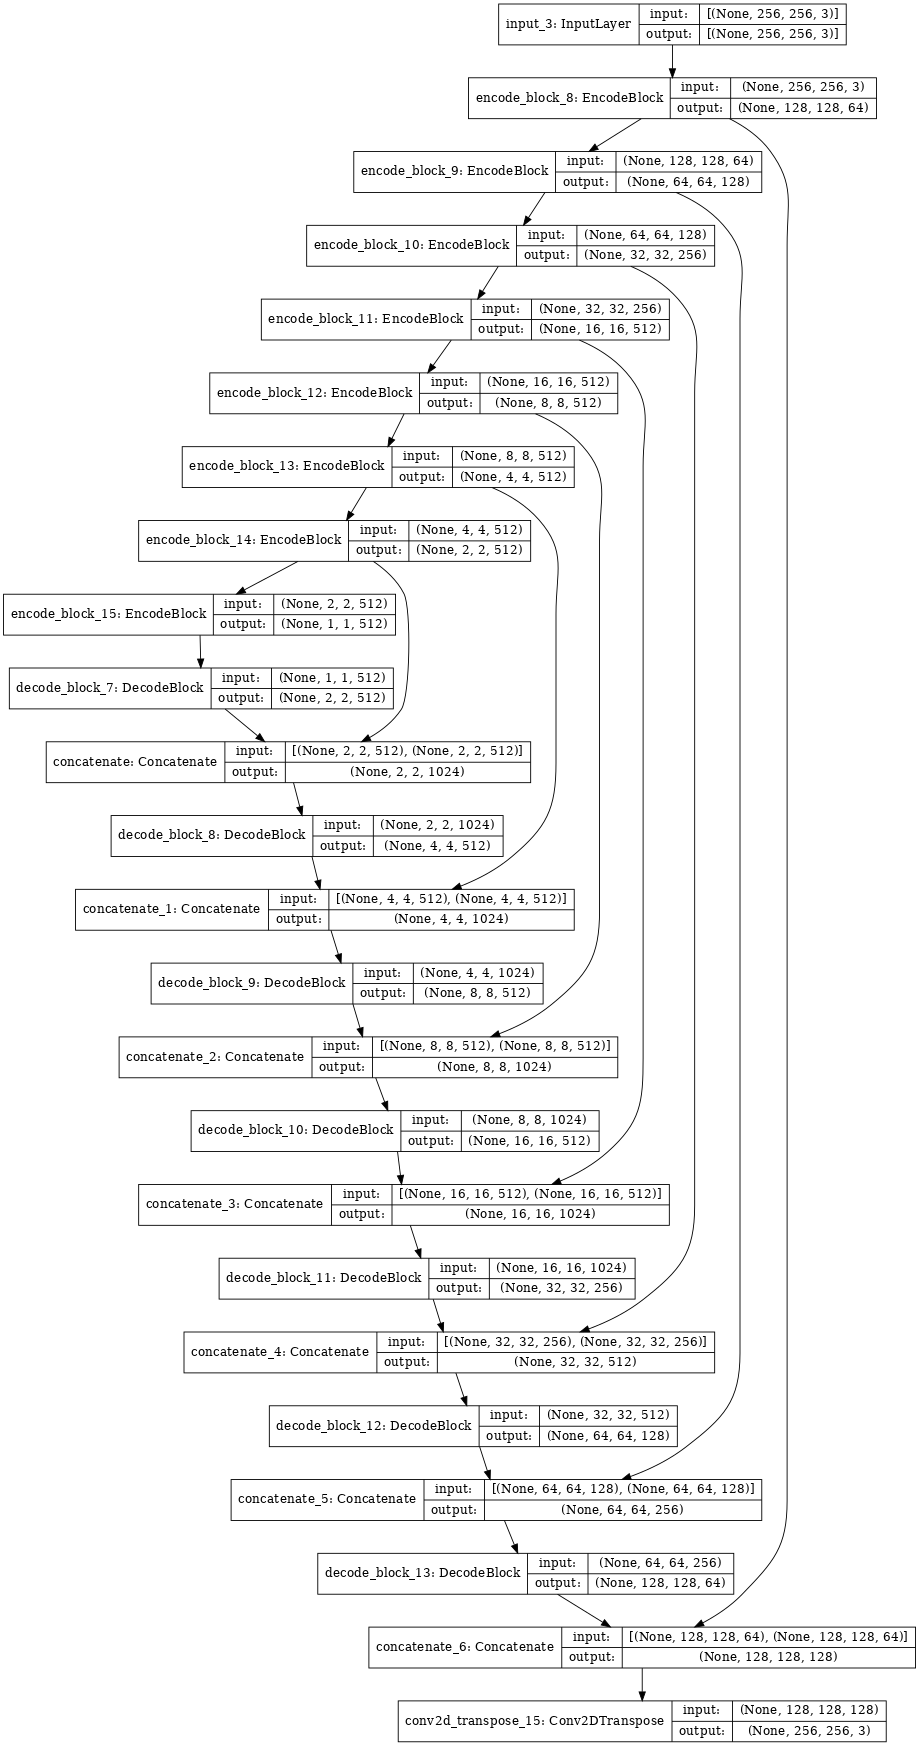

In [12]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        #skip connection을 위한 리스트에 Encoder 출력 할당
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
            
        #Encoder의 마지막 출력은 features에서 제외
        features = features[:-1]
        
        #features의 역순으로 연결            
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
    def get_plot(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        model = Model(inputs, self.call(inputs))
        return tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

UNetGenerator().get_plot()

## 3. PatchGAN Discriminator 구현

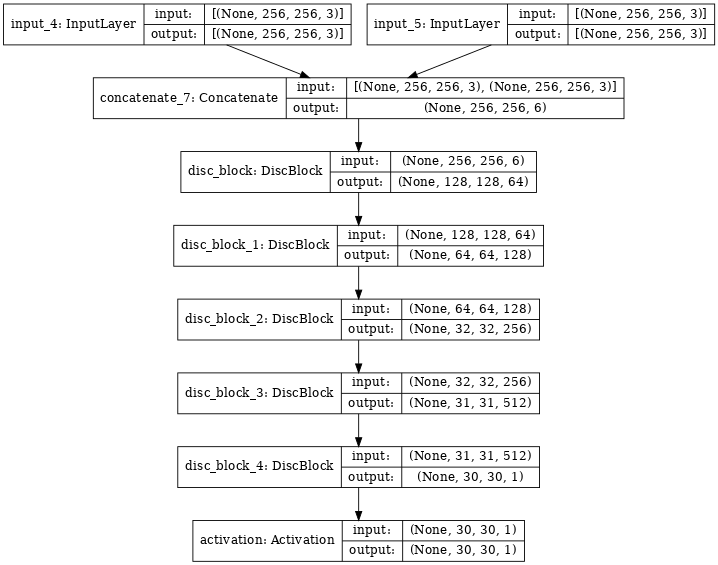

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x
    

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        # custom padding: block 4>>5>>6(32>>31>>30)
        # receptive field: (1>>4>>7>>16>>34>>70)
        for i, f in enumerate(filters):
            if i < 3:
                stride = 2
                custom_pad = False
            else:
                stride = 1
                custom_pad = True
            
            use_bn = not(i==0 or i==len(filters)-1)
            act = not(i== len(filters) - 1)
            
            self.blocks.append(DiscBlock(f, stride, custom_pad, use_bn, act))

        self.sigmoid = layers.Activation('sigmoid')
        
    def call(self, x, y):
        x = self.blocks[0]([x, y])
        for block in self.blocks[1:]:
            x = block(x)
        out = self.sigmoid(x)
        return out
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
    def get_plot(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        model = Model((x, y), self.call(x, y))
        return tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
    
Discriminator().get_plot()

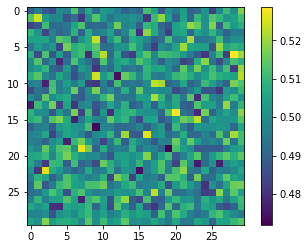

In [14]:
#Discriminator output: Patch 70x70 T/F classification
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 4. Generator/Discriminator 손실 및 훈련 루프 정의

### 4-1. 손실 함수 및 훈련 루프 정의

In [15]:
from tensorflow.keras import losses
from tensorflow.keras import optimizers

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()
generator_optimizer = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
discriminator_optimizer = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

#Generator loss, L1 loss
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

#Discriminator loss
def get_disc_loss(fake_disc, real_disc):
    disc_loss = bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)
    return disc_loss

@tf.function
def train_step(input_image, real_image):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # 생성자에 입력 스케치를 전달하여 가짜 컬러 이미지 생성
        fake_image = generator(input_image, training=True)

        # 판별자에 실제 컬러 이미지와 가짜 컬러 이미지를 전달하여 판별 결과 계산
        real_disc = discriminator(real_image, input_image, training=True)
        fake_disc = discriminator(fake_image, input_image, training=True)
        
        #Generator loss + lambda * L1 loss (lambda = 100)
        gene_loss, l1_loss = get_gene_loss(fake_image, real_image, fake_disc)
        gene_total_loss = gene_loss + 100*l1_loss
        
        #Discriminator loss
        disc_loss = get_disc_loss(fake_disc, real_disc)
        

    # 생성자와 판별자에 대한 그래디언트 계산
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_total_loss, l1_loss, disc_loss

### 4-2. 학습

In [16]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

history = {'g_tot_loss':[], 'l1_loss':[], 'd_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_dataset):
        g_tot_loss, l1_loss, d_loss = train_step(input_image, real_image)
        
        history['g_tot_loss'].append(g_tot_loss)
        history['l1_loss'].append(l1_loss)
        history['d_loss'].append(d_loss)        
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 500 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_tot_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[500]                     
Generator_loss:23.4078                     
L1_loss:0.2275                     
Discriminator_loss:1.0051

EPOCH[1] - STEP[1000]                     
Generator_loss:21.4110                     
L1_loss:0.1952                     
Discriminator_loss:1.7403

EPOCH[2] - STEP[500]                     
Generator_loss:18.1714                     
L1_loss:0.1674                     
Discriminator_loss:0.5541

EPOCH[2] - STEP[1000]                     
Generator_loss:17.6155                     
L1_loss:0.1503                     
Discriminator_loss:3.2171

EPOCH[3] - STEP[500]                     
Generator_loss:19.6144                     
L1_loss:0.1682                     
Discriminator_loss:0.7088

EPOCH[3] - STEP[1000]                     
Generator_loss:20.1260                     
L1_loss:0.1892                     
Discriminator_loss:0.8358

EPOCH[4] - STEP[500]                     
Generator_loss:22.8493                     
L1_loss:0.2121   

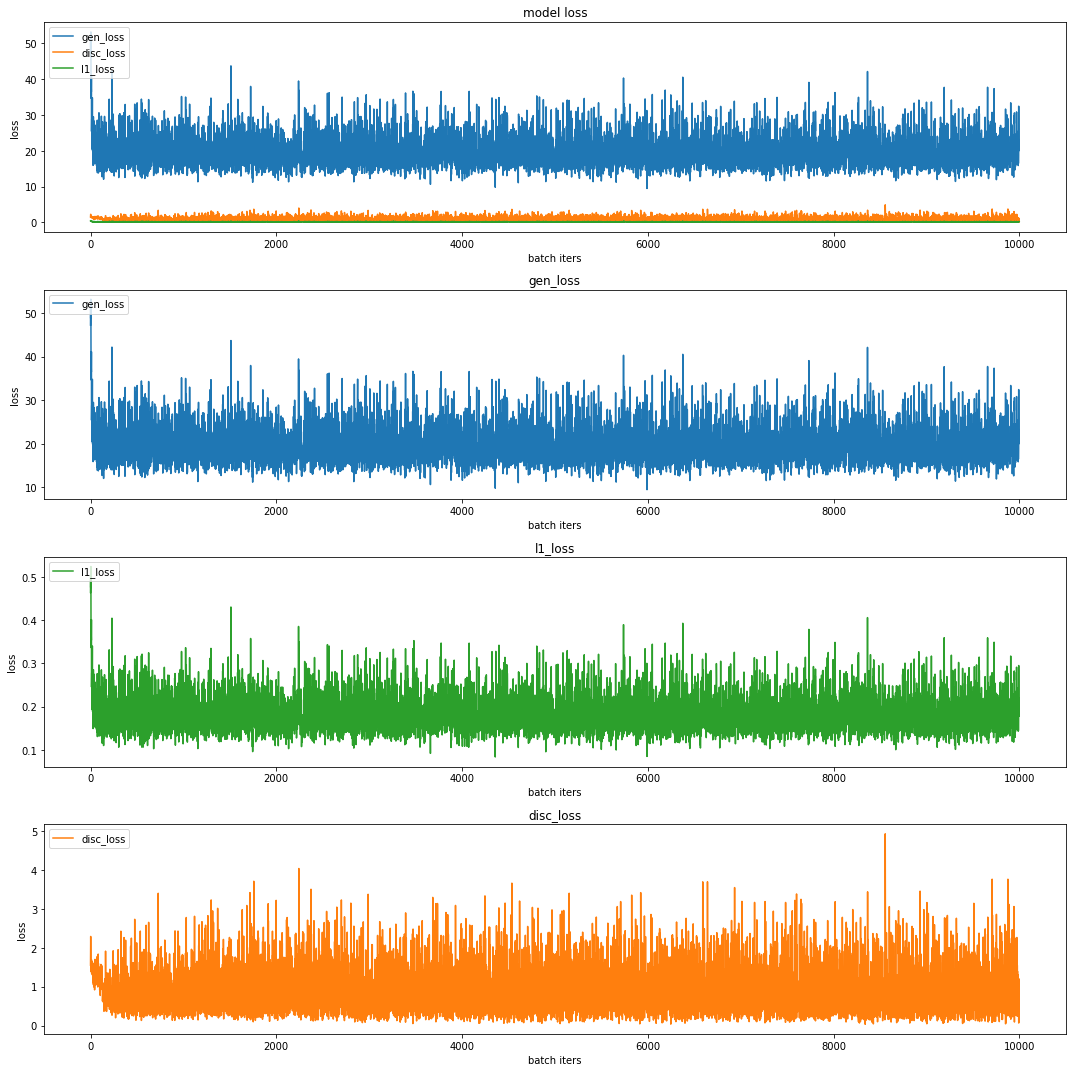

In [17]:
plt.figure(figsize=(15,15))

plt.subplot(411)  
plt.plot(history['g_tot_loss'])  
plt.plot(history['d_loss'])
plt.plot(history['l1_loss'])
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['gen_loss', 'disc_loss', 'l1_loss'], loc='upper left')

plt.subplot(412)  
plt.plot(history['g_tot_loss'], 'tab:blue')   
plt.title('gen_loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['gen_loss'], loc='upper left')

plt.subplot(413)  
plt.plot(history['l1_loss'], 'tab:green')   
plt.title('l1_loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['l1_loss'], loc='upper left')  

plt.subplot(414)  
plt.plot(history['d_loss'], 'tab:orange')   
plt.title('disc_loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['disc_loss'], loc='upper left')  

plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


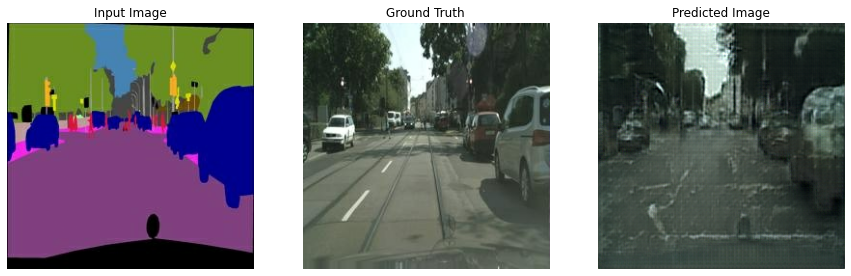

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


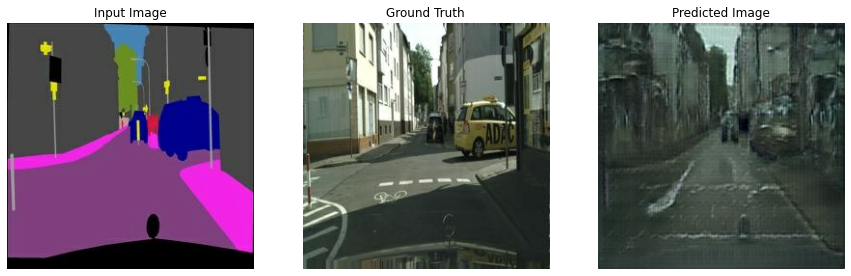

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


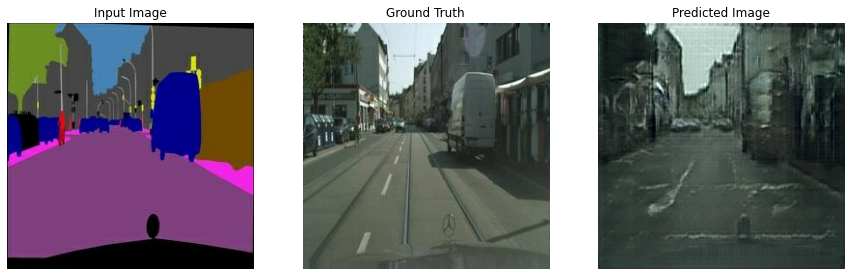

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


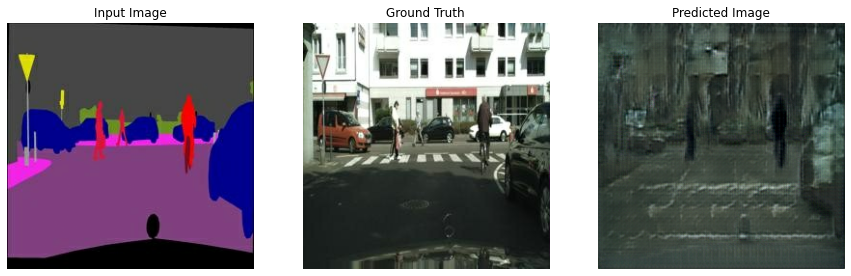

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


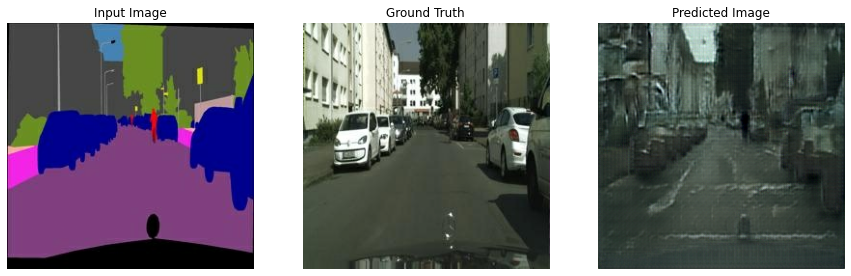

In [18]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)
